<img src="https://news.illinois.edu/files/6367/543635/116641.jpg" alt="University of Illinois" width="250px"/>

# Linear Regression
By Richard Sowers
* <r-sowers@illinois.edu>
* <https://publish.illinois.edu/r-sowers/>

Copyright 2023 University of Illinois Board of Trustees. All Rights Reserved.

# Setup

## imports and graphics configurations

In [ ]:
import os
import numpy
import pandas
import time
import random
import matplotlib
#%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import scipy.stats
#from pandas.plotting import autocorrelation_plot
import matplotlib.offsetbox as offsetbox
from matplotlib.ticker import StrMethodFormatter

def saver(fname,dpi=600):
    plt.savefig(fname+".png",bbox_inches="tight",dpi=dpi)

def legend(pos="bottom",ncol=3,extra=False):
    if pos=="bottom":
        extra = 0.15 if extra else 0
        plt.legend(bbox_to_anchor=(0.5,-0.2-extra), loc='upper center',facecolor="lightgray",ncol=ncol)
    elif pos=="side":
        plt.legend(bbox_to_anchor=(1.1,0.5), loc='center left',facecolor="lightgray",ncol=1)

def textbox(txt,fname=None):
    plt.figure(figsize=(1,1))
    plt.gca().add_artist(offsetbox.AnchoredText("\n".join(txt), loc="center",prop=dict(size=30)))
    plt.axis('off')
    if fname is not None:
        saver(fname)
    plt.show()
    plt.close()

In [ ]:
#for some reason, this needs to be in a separate cell
params={
    "font.size":15,
    "lines.linewidth":5
}
plt.rcParams.update(params)

In [ ]:
pngfiles=[f for f in os.listdir(".") if f.endswith(".png")]
print("existing png files: "+str(pngfiles))
#print([os.remove(f) for f in pngfiles])

existing png files: []


In [ ]:
def getfile(location_pair,**kwargs): #tries to get local version and then defaults to google drive version
    (loc,gdrive)=location_pair
    try:
        out=pandas.read_csv(loc,**kwargs)
    except FileNotFoundError:
        print("local file not found; accessing Google Drive")
        loc = 'https://drive.google.com/uc?export=download&id='+gdrive.split('/')[-2]
        out=pandas.read_csv(loc,**kwargs)
    return out

fname=("redfin_data.csv","https://drive.google.com/file/d/1PA1ixsL-sMfJclTeJWc2lVifp5FtIYpn/view?usp=sharing")
data=getfile(fname)
data.head()

local file not found; accessing Google Drive


,SALE TYPE,SOLD DATE,PROPERTY TYPE,ADDRESS,CITY,STATE OR PROVINCE,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,...,STATUS,NEXT OPEN HOUSE START TIME,NEXT OPEN HOUSE END TIME,URL (SEE https://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING),SOURCE,MLS#,FAVORITE,INTERESTED,LATITUDE,LONGITUDE
0,MLS Listing,NaN,Single Family Residential,333 Dodge Ave,Evanston,IL,60202,339900,3.0,2.0,...,Active,NaN,NaN,https://www.redfin.com/IL/Evanston/333-Dodge-A...,MRED,11818689,N,Y,42.024226,-87.699124
1,MLS Listing,NaN,Condo/Co-op,2254 Sherman Ave #2,Evanston,IL,60201,199000,2.0,1.0,...,Active,NaN,NaN,https://www.redfin.com/IL/Evanston/2254-Sherma...,MRED,11831019,N,Y,42.059131,-87.682292
2,MLS Listing,NaN,Single Family Residential,2701 Noyes St,Evanston,IL,60201,1075000,5.0,3.5,...,Active,August-5-2023 11:00 AM,August-5-2023 01:00 PM,https://www.redfin.com/IL/Evanston/2701-Noyes-...,MRED,11850222,N,Y,42.058239,-87.710956
3,MLS Listing,NaN,Townhouse,1507 Wilder St,Evanston,IL,60202,825000,4.0,2.5,...,Active,NaN,NaN,https://www.redfin.com/IL/Evanston/1507-Wilder...,MRED,11849960,N,Y,42.040571,-87.693225
4,MLS Listing,NaN,Single Family Residential,9409 Crawford Ave,Evanston,IL,60203,525000,3.0,1.5,...,Active,August-6-2023 02:00 PM,August-6-2023 04:00 PM,https://www.redfin.com/IL/Evanston/9409-Crawfo...,MRED,11849554,N,Y,42.052003,-87.727151


##  configuration variables

In [ ]:
url="https://www.redfin.com"
fname=("redfin_data.csv","https://drive.google.com/file/d/1ei7JaZ4M1lrw3TyYcWozESi8HrHccnUx/view?usp=sharing")
plot_title="Home Asking Price (Redfin)"
data_color="red"
markersize=2
thinlinesize=2
textboxsize=(5,0.5)

# main

In [ ]:
(feature,featurescale,featurename)=("SQUARE FEET",1000,"SQUARE FEET/1000")
(label,labelscale,labelname)=("PRICE",1.0E6,"PRICE/$1M")

In [ ]:
text="\\begin{{center}}data provided by \\url{{{0:s}}}, a national real estate brokerage\\end{{center}}"
with open("dataurl.tex","w") as f:
    f.write(text.format(url))
f.close()

## load data

In [ ]:
data_raw=getfile(fname)
data_raw.head()

local file not found; accessing Google Drive


,SALE TYPE,SOLD DATE,PROPERTY TYPE,ADDRESS,CITY,STATE OR PROVINCE,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,...,STATUS,NEXT OPEN HOUSE START TIME,NEXT OPEN HOUSE END TIME,URL (SEE https://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING),SOURCE,MLS#,FAVORITE,INTERESTED,LATITUDE,LONGITUDE
0,MLS Listing,NaN,Condo/Co-op,1316 Maple Ave Unit A3,Evanston,IL,60201,549000,3.0,2.5,...,Active,NaN,NaN,https://www.redfin.com/IL/Evanston/1316-Maple-...,MRED,11329016,N,Y,42.041893,-87.685418
1,MLS Listing,NaN,Condo/Co-op,1640 Maple Ave #1608,Evanston,IL,60201,925000,2.0,2.5,...,Active,NaN,NaN,https://www.redfin.com/IL/Evanston/1640-Maple-...,MRED,11324990,N,Y,42.048207,-87.685582
2,MLS Listing,NaN,Single Family Residential,9400 Drake Ave,Evanston,IL,60203,699900,5.0,2.0,...,Active,NaN,NaN,https://www.redfin.com/IL/Evanston/9400-Drake-...,MRED,11328594,N,Y,42.051958,-87.717069
3,MLS Listing,NaN,Condo/Co-op,2320 Central St #304,Evanston,IL,60201,315000,2.0,2.0,...,Active,NaN,NaN,https://www.redfin.com/IL/Evanston/2320-Centra...,MRED,11328430,N,Y,42.064059,-87.705756
4,MLS Listing,NaN,Townhouse,9032 Forestview Rd,Evanston,IL,60203,385000,2.0,2.5,...,Active,NaN,NaN,https://www.redfin.com/IL/Evanston/9032-Forest...,MRED,11328152,N,Y,42.045487,-87.714740


In [ ]:
data=data_raw.copy()

In [ ]:
data.head(1).transpose().to_latex(buf="sample_raw_data.tex",bold_rows=True)

<ipython-input-10-40e203ef9d92>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  data.head(1).transpose().to_latex(buf="sample_raw_data.tex",bold_rows=True)


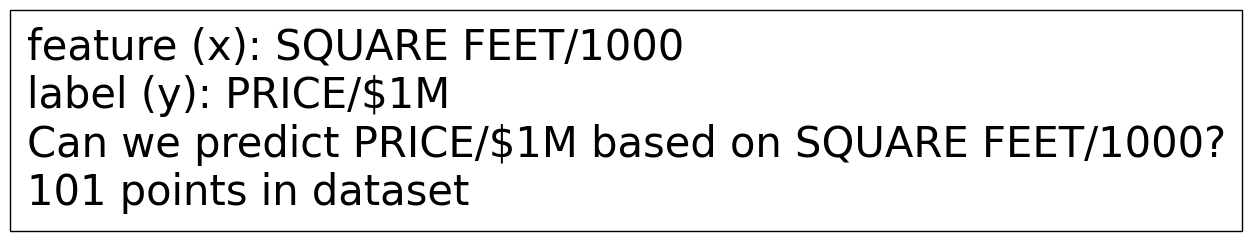

In [ ]:
text=[]
text.append(f"feature (x): {featurename:s}")
text.append(f"label (y): {labelname:s}")
text.append(f"Can we predict {labelname:s} based on {featurename:s}?")
text.append(f"{len(data):d} points in dataset")
textbox(text,fname="dataset")

In [ ]:
XY=data[[feature,label]].dropna(axis='index')
XY.columns=[featurename,labelname]
XY[featurename]=XY[featurename]/featurescale
XY[labelname]=XY[labelname]/labelscale
XY.head()

,SQUARE FEET/1000,PRICE/$1M
0,2.000,0.5490
1,2.138,0.9250
2,2.198,0.6999
3,1.426,0.3150
6,2.170,0.7390


In [ ]:
XY.head(5).to_latex(buf="sample_data.tex",bold_rows=True,index=False)

<ipython-input-13-0eedfc78250b>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  XY.head(5).to_latex(buf="sample_data.tex",bold_rows=True,index=False)


In [ ]:
X=XY[featurename].squeeze()
Y=XY[labelname].squeeze()
m_opt,b_opt,_,_,_=scipy.stats.linregress(X,Y)
print(f"m_opt = {m_opt:} and b_opt= {b_opt:}")

m_opt = 0.3558718716000352 and b_opt= -0.1403975081292415


In [ ]:
Xmax=X.mean()+3*X.std()
Xmax

5.297219240198255

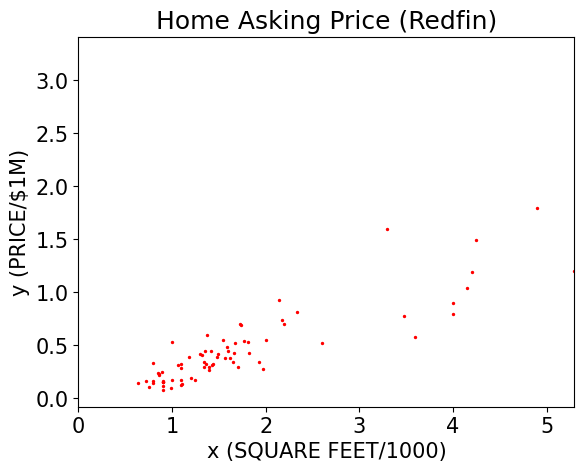

In [ ]:
plt.figure()
plt.scatter(X,Y,color=data_color,s=markersize)
title=[]
title.append(plot_title)
plt.title("\n".join(title))
plt.xlabel(f"x ({featurename:s})")
plt.ylabel(f"y ({labelname:s})")
plt.xlim(0,Xmax)
#tick = mtick.StrMethodFormatter("${x:,.0f}")
#plt.gca().yaxis.set_major_formatter(tick)
saver("xyplot")
plt.show()
plt.close()

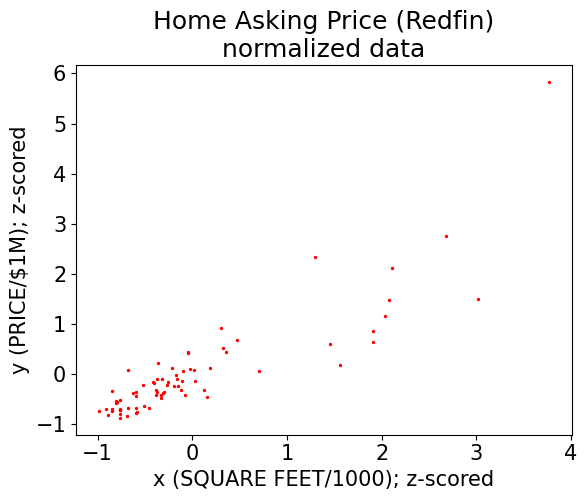

In [ ]:
X_scored=scipy.stats.zscore(X)
Y_scored=scipy.stats.zscore(Y)
plt.figure()
plt.scatter(X_scored,Y_scored,color=data_color,s=markersize)
title=[]
title.append(plot_title)
title.append("normalized data")
plt.title("\n".join(title))
plt.xlabel(f"x ({featurename:s}); z-scored")
plt.ylabel(f"y ({labelname:s}); z-scored")
saver("xyplot_scored")
plt.show()
plt.close()

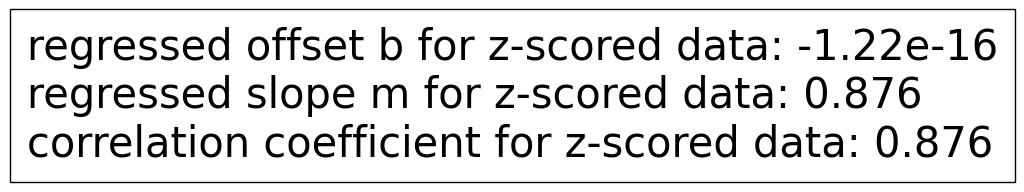

In [ ]:
m_opt_scored,b_opt_scored,_,_,_=scipy.stats.linregress(X_scored,Y_scored)
corcoeff=numpy.corrcoef(X_scored,Y_scored)[0,1]
text=[]
text.append(f"regressed offset b for z-scored data: {b_opt_scored:.2e}")
text.append(f"regressed slope m for z-scored data: {m_opt_scored:.3f}")
text.append(f"correlation coefficient for z-scored data: {corcoeff:.3f}")
textbox(text,fname="scored_regression")

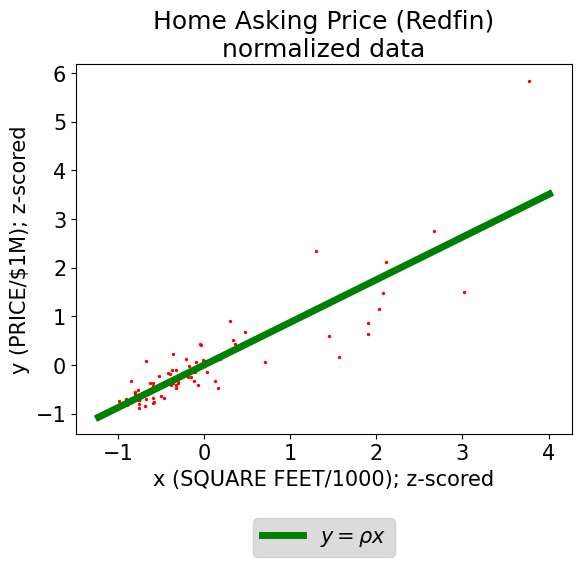

In [ ]:
X_scored=scipy.stats.zscore(X)
Y_scored=scipy.stats.zscore(Y)
plt.figure()
plt.scatter(X_scored,Y_scored,color=data_color,s=markersize)
x_range=numpy.array(plt.xlim())
plt.plot(x_range,corcoeff*x_range,color="green",label=r"$y=\rho x$")
title=[]
title.append(plot_title)
title.append("normalized data")
plt.title("\n".join(title))
plt.xlabel(f"x ({featurename:s}); z-scored")
plt.ylabel(f"y ({labelname:s}); z-scored")
legend("bottom")
saver("xyplot_scored_line")
plt.show()
plt.close()

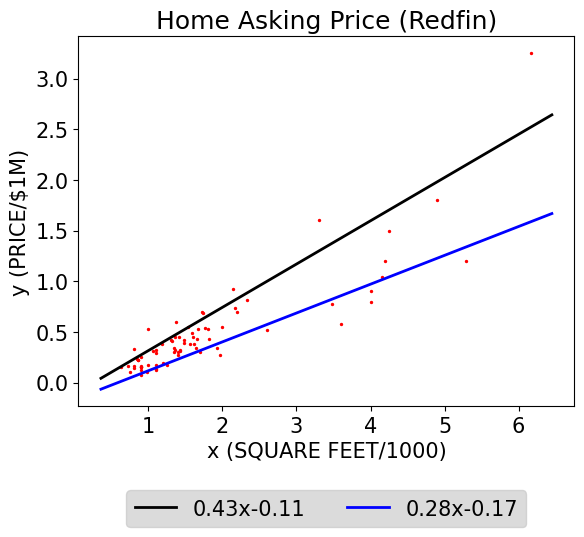

In [ ]:
(m_1,b_1,firstcolor)=(1.2*m_opt,0.8*b_opt,"black")
(m_2,b_2,secondcolor)=(0.8*m_opt,1.2*b_opt,"blue")
plt.figure()
plt.scatter(X,Y,color=data_color,s=markersize)
xlims=numpy.array(plt.gca().get_xlim())
plt.plot(xlims,m_1*xlims+b_1,label=f"{m_1:.2f}x{b_1:+.2f}",color=firstcolor,linewidth=thinlinesize)
plt.plot(xlims,m_2*xlims+b_2,label=f"{m_2:.2f}x{b_2:+.2f}",color=secondcolor,linewidth=thinlinesize)
title=[]
title.append(plot_title)
plt.title("\n".join(title))
plt.xlabel(f"x ({featurename:s})")
plt.ylabel(f"y ({labelname:s})")
#tick = mtick.StrMethodFormatter("${x:,.0f}")
#plt.gca().yaxis.set_major_formatter(tick)
legend("bottom")
saver("bestlines")
plt.show()
plt.close()

In [ ]:
class LinearRegression:
    def __init__(self,x,y):
        self.xvals=numpy.array(x)
        self.yvals=numpy.array(y)

        self.XXvals=numpy.vstack([self.xvals,[1]*len(self.xvals)])
        self.reset()

    def reset(self):
        self.ctr=0
        self.callbacktext=[]

    @staticmethod
    def linear_function(p):
        (m,b)=p
        def l_f(x):
            return m*x+b
        return l_f

    def Loss(self,p,include_gradient=False):
        err=self.yvals-self.linear_function(p)(self.xvals)
        loss=numpy.mean(err**2)
        if include_gradient:
            out=-2*numpy.mean(err*self.XXvals,axis=1)
            return (loss,out)
        else:
            return loss

    def metric(self,p):
        (m,b)=p
        rel_err=numpy.abs(self.yvals-self.linear_function(p)(self.xvals))/self.yvals
        return numpy.mean(rel_err)

    def callback(self,x,verbose=False):
        (m,b)=p
        outstr="ctr={0:}; (m,b)=({1:.3f},{2:.2E}); error={3:.2E}".format(self.ctr,m,b,self.Loss(p))
        self.callbacktext.append(outstr)
        if verbose:
            print(outstr)
        self.ctr+=1

LR=LinearRegression(X,Y)

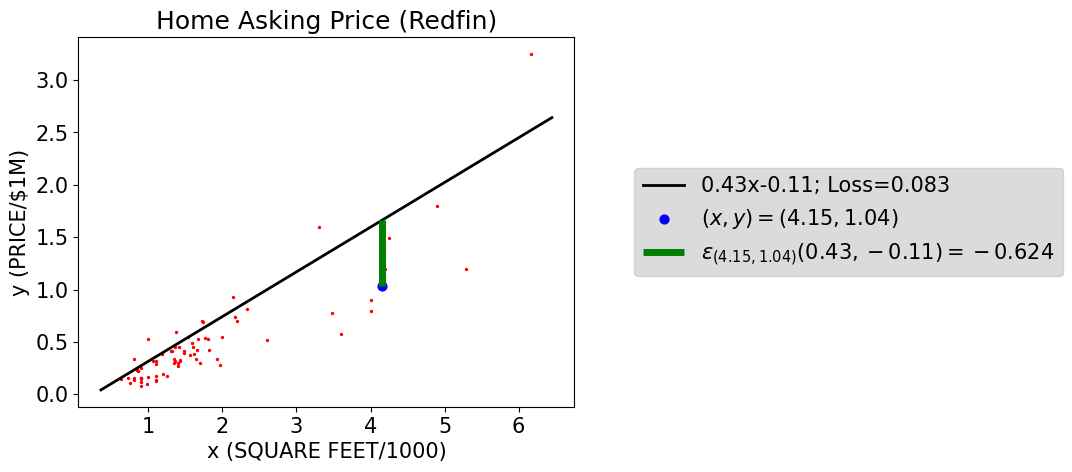

In [ ]:
(m_1,b_1,firstcolor)=(1.2*m_opt,0.8*b_opt,"black")
lf=LR.linear_function((m_1,b_1))
temp=pandas.concat([X,Y],axis="columns")
temp["line"]=lf(X)
temp["eps"]=Y-temp["line"]
tempsorted=temp.sort_values(by="eps",axis="index",ascending=False)
N_test=-5
toplot=tempsorted.iloc[N_test]
#N=toplot.name
plt.scatter(X,Y,color=data_color,s=markersize)
xlims=numpy.array(plt.gca().get_xlim())
plt.plot(xlims,lf(xlims),label="{0:.2f}x{1:+.2f}; Loss={2:.3f}".format(m_1,b_1,LR.Loss((m_1,b_1))),color=firstcolor,linewidth=thinlinesize)
plt.scatter(toplot[featurename],toplot[labelname],color="blue",s=markersize*20,
            label=r"$(x,y)=({0:.2f},{1:.2f})$".format(toplot[featurename],toplot[labelname]))
plt.vlines(toplot[featurename],ymin=toplot["line"],ymax=toplot[labelname],color="green",linewidth=5,
          label=r"$\varepsilon_{{({0:.2f},{1:.2f})}}({2:.2f},{3:.2f})={4:.3f}$".format(toplot[featurename],toplot[labelname],m_1,b_1,toplot["eps"]))
title=[]
title.append(plot_title)
plt.title("\n".join(title))
plt.xlabel(f"x ({featurename:s})")
plt.ylabel(f"y ({labelname:s})")
#tick = mtick.StrMethodFormatter("${x:,.0f}")
#plt.gca().yaxis.set_major_formatter(tick)
legend("side",ncol=1)
saver("singleerror")
plt.show()
plt.close()

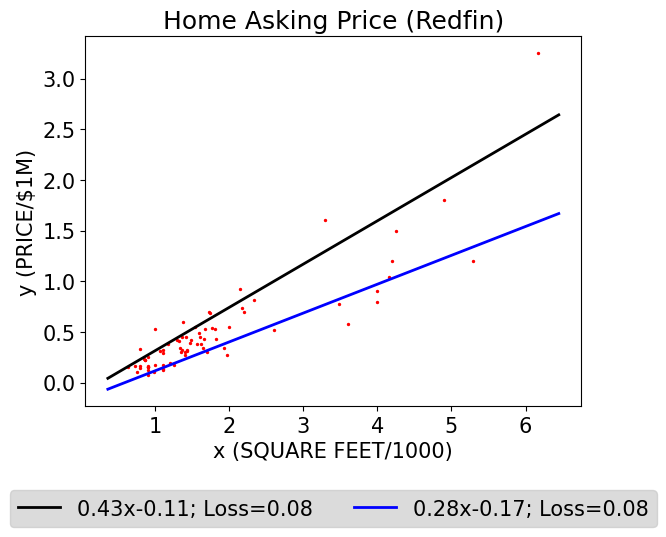

In [ ]:
(m_1,b_1,firstcolor)=(1.2*m_opt,0.8*b_opt,"black")
(m_2,b_2,secondcolor)=(0.8*m_opt,1.2*b_opt,"blue")
plt.figure()
plt.scatter(X,Y,color=data_color,s=markersize)
xlims=numpy.array(plt.gca().get_xlim())
plt.plot(xlims,LR.linear_function([m_1,b_1])(xlims),label="{0:.2f}x{1:+.2f}; Loss={2:.2f}".format(m_1,b_1,LR.Loss([m_1,b_1])),color=firstcolor,linewidth=thinlinesize)
plt.plot(xlims,LR.linear_function([m_2,b_2])(xlims),label="{0:.2f}x{1:+.2f}; Loss={2:.2f}".format(m_2,b_2,LR.Loss([m_2,b_2])),color=secondcolor,linewidth=thinlinesize)
title=[]
title.append(plot_title)
plt.title("\n".join(title))
plt.xlabel(f"x ({featurename:s})")
plt.ylabel(f"y ({labelname:s})")
#tick = mtick.StrMethodFormatter("${x:,.0f}")
#plt.gca().yaxis.set_major_formatter(tick)
legend("bottom")
saver("costlines")
plt.show()
plt.close()

In [ ]:
(dm_opt,db_opt)=(2*numpy.abs(m_opt),10*numpy.abs(b_opt))
Mvals = numpy.linspace(m_opt-dm_opt,m_opt+dm_opt)
Bvals = numpy.linspace(b_opt-db_opt,b_opt+db_opt)
Mgrid, Bgrid = numpy.meshgrid(Mvals, Bvals)
Err=numpy.array([[LR.Loss([m,b]) for m in Mvals] for b in Bvals])
Err=numpy.sqrt(Err-numpy.min(Err))
#levels=numpy.linspace(start=minE,stop=minE+numpy.ptp(Err)/10,num=10)
levels=numpy.linspace(start=numpy.min(Err),stop=numpy.max(Err),num=10)

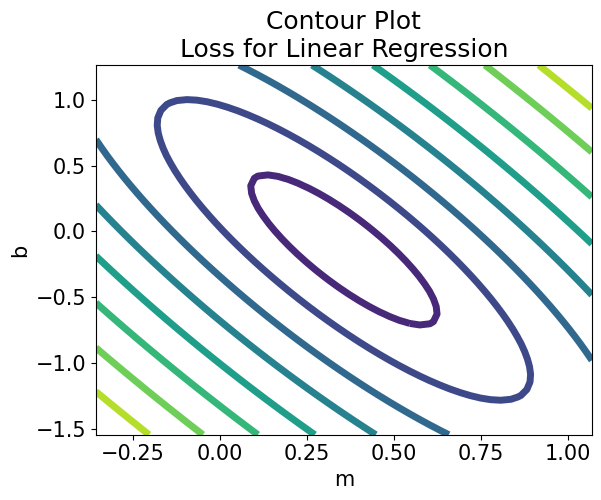

In [ ]:
plt.figure
plt.contour(Mvals,Bvals,Err,levels=levels)
title=[]
title.append("Contour Plot")
title.append("Loss for Linear Regression")
plt.title("\n".join(title))
plt.xlim(0.62,0.72)
plt.xlim(m_opt-dm_opt,m_opt+dm_opt)
plt.ylim(b_opt-db_opt,b_opt+db_opt)
plt.xlabel("m")
plt.ylabel("b")
saver("contour")
plt.show()
plt.close()

In [ ]:
(m_init,b_init)=(1.8*m_opt,1.1*b_opt)
_,(dm_init,db_init)=LR.Loss([m_init,b_init],include_gradient=True)

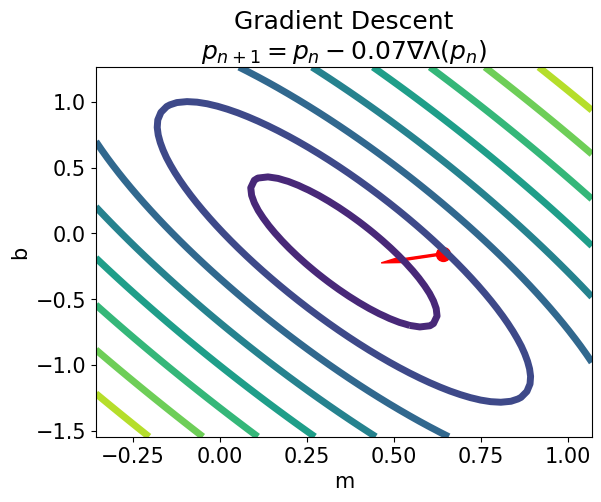

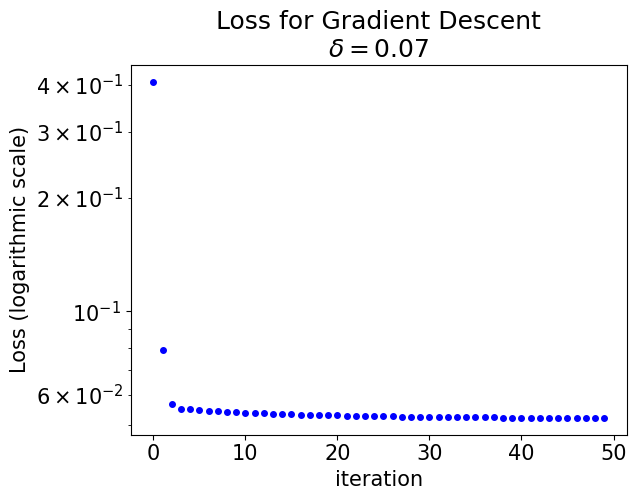

In [ ]:
delta=0.07
plt.figure
plt.contour(Mvals,Bvals,Err,levels=levels)
title=[]
title.append("Gradient Descent")
title.append(r"$p_{{n+1}}=p_n-{0:.2f}\nabla \Lambda(p_n)$".format(delta))
plt.scatter(m_init,b_init,s=100,color="red")
plt.arrow(m_init,b_init,-dm_init*delta,-db_init*delta,width=.2*delta,color="r",length_includes_head=True)
plt.title("\n".join(title))
plt.xlim(0.62,0.72)
plt.xlim(m_opt-dm_opt,m_opt+dm_opt)
plt.ylim(b_opt-db_opt,b_opt+db_opt)
plt.xlabel("m")
plt.ylabel("b")
saver("contour_smalldelta")
plt.show()
plt.close()

state=[m_init,b_init]
Losses=[]
N=50
for n in range(N):
    loss,gradient=LR.Loss(state,include_gradient=True)
    Losses.append(loss)
    state=state-delta*gradient

title=[]
title.append("Loss for Gradient Descent")
title.append(r"$\delta={:.2f}$".format(delta))
plt.figure()
plt.semilogy(Losses, 'bo',ms=4)
plt.ylabel("Loss (logarithmic scale)")
plt.xlabel("iteration")
plt.title("\n".join(title))
saver("decreasing_cost")
plt.show()
plt.close()

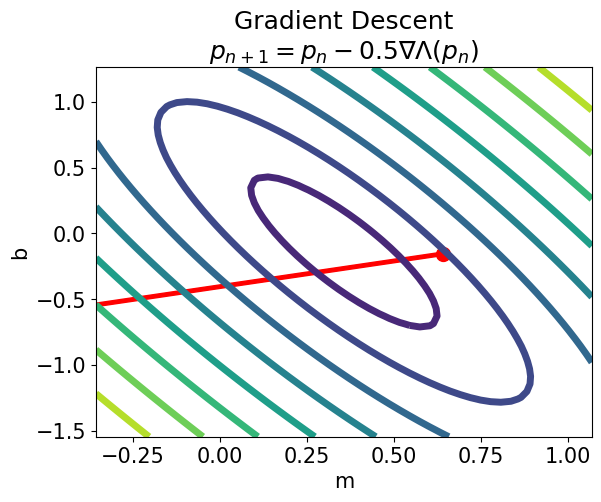

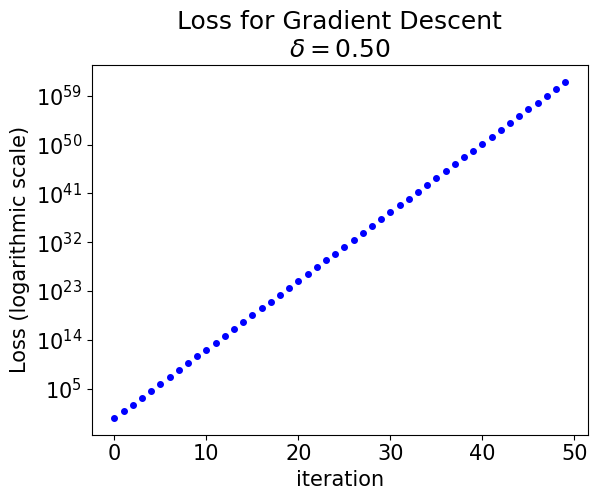

In [ ]:
delta=0.5
plt.figure
plt.contour(Mvals,Bvals,Err,levels=levels)
title=[]
title.append("Gradient Descent")
title.append(r"$p_{{n+1}}=p_n-{0:}\nabla \Lambda(p_n)$".format(delta))
plt.scatter(m_init,b_init,s=100,color="red")
plt.arrow(m_init,b_init,-dm_init*delta,-db_init*delta,width=.05*delta,color="r",length_includes_head=True)
plt.title("\n".join(title))
plt.xlim(0.62,0.72)
plt.xlim(m_opt-dm_opt,m_opt+dm_opt)
plt.ylim(b_opt-db_opt,b_opt+db_opt)
plt.xlabel("m")
plt.ylabel("b")
saver("contour_largedelta")
plt.show()
plt.close()

state=[m_init,b_init]
Losses=[]
N=50
for n in range(N):
    loss,gradient=LR.Loss(state,include_gradient=True)
    Losses.append(loss)
    state=state-delta*gradient

title=[]
title.append("Loss for Gradient Descent")
title.append(r"$\delta={:.2f}$".format(delta))
plt.figure()
plt.semilogy(Losses, 'bo',ms=4)
plt.ylabel("Loss (logarithmic scale)")
plt.xlabel("iteration")
plt.title("\n".join(title))
saver("increasing_cost")
plt.show()
plt.close()

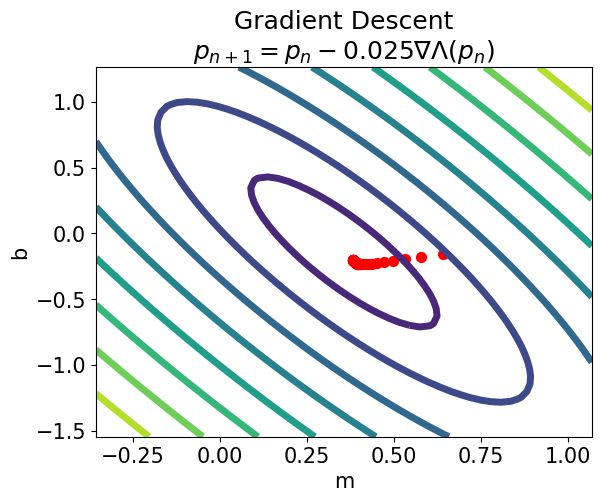

In [ ]:
delta=0.025
state=[m_init,b_init]
states=[state]
Losses=[]
N=50
for n in range(N):
    loss,gradient=LR.Loss(state,include_gradient=True)
    Losses.append(loss)
    state=state-delta*gradient
    states.append(state)


states_x=[x for (x,_) in states]
states_y=[y for (_,y) in states]
plt.figure
plt.contour(Mvals,Bvals,Err,levels=levels)
title=[]
title.append("Gradient Descent")
title.append(r"$p_{{n+1}}=p_n-{0:}\nabla \Lambda(p_n)$".format(delta))
plt.scatter(states_x,states_y,s=50,color="red")
plt.title("\n".join(title))
plt.xlim(0.62,0.72)
plt.xlim(m_opt-dm_opt,m_opt+dm_opt)
plt.ylim(b_opt-db_opt,b_opt+db_opt)
plt.xlabel("m")
plt.ylabel("b")
saver("grad_flow")
plt.show()
plt.close()

0.3558718716000352
-0.1403975081292415


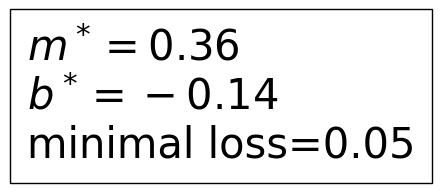

In [ ]:
slope,intercept,_,_,_=scipy.stats.linregress(X,Y)
mincost=LR.Loss([slope,intercept])
print(slope)
print(intercept)
text=[]
text.append(r"$m^*={0:.2f}$".format(slope))
text.append(r"$b^*={0:.2f}$".format(intercept))
text.append("minimal loss={0:.2f}".format(mincost))
textbox(text,fname="bestline")

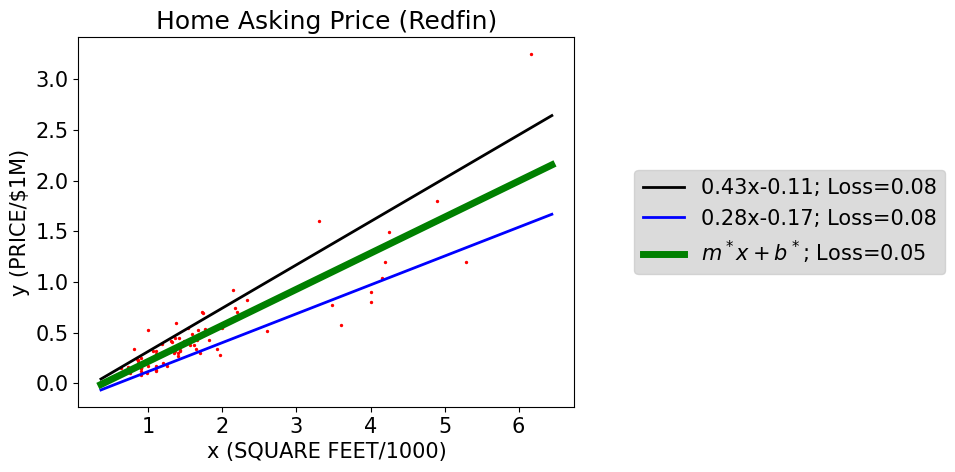

In [ ]:
(m_1,b_1,firstcolor)=(1.2*m_opt,0.8*b_opt,"black")
(m_2,b_2,secondcolor)=(0.8*m_opt,1.2*b_opt,"blue")
(m_best,b_best,bestcolor)=(slope,intercept,"green")
plt.figure()
plt.scatter(X,Y,color=data_color,s=markersize)
xlims=numpy.array(plt.gca().get_xlim())
plt.plot(xlims,LR.linear_function([m_1,b_1])(xlims),label="{0:.2f}x{1:+.2f}; Loss={2:.2f}".format(m_1,b_1,LR.Loss([m_1,b_1])),color=firstcolor,linewidth=thinlinesize)
plt.plot(xlims,LR.linear_function([m_2,b_2])(xlims),label="{0:.2f}x{1:+.2f}; Loss={2:.2f}".format(m_2,b_2,LR.Loss([m_2,b_2])),color=secondcolor,linewidth=thinlinesize)
plt.plot(xlims,LR.linear_function([m_best,b_best])(xlims),label=r"$m^* x+b^*$; Loss={2:.2f}".format(m_best,b_best,LR.Loss([m_best,b_best])),color=bestcolor)
title=[]
title.append(plot_title)
plt.title("\n".join(title))
plt.xlabel("x ({0:s})".format(featurename))
plt.ylabel("y ({0:s})".format(labelname))
legend("side")
saver("bestcostlines")
plt.show()
plt.close()

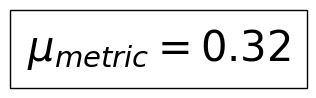

In [ ]:
text=[]
text.append(r"$\mu_{{metric}}={0:.2f}$".format(LR.metric([slope,intercept])))
textbox(text,fname="metric")

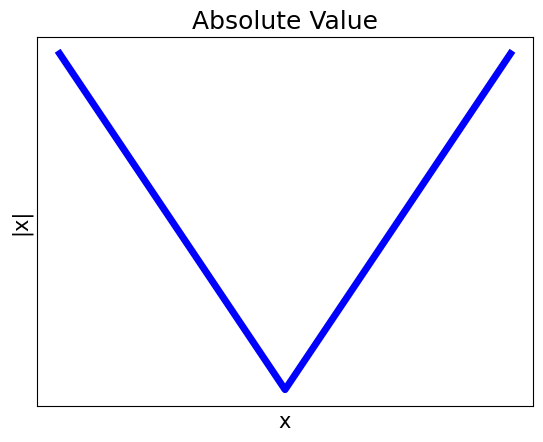

In [ ]:
plt.figure()
plt.plot([-1,0,1],[1,0,1],color="blue")
plt.xticks([],[])
plt.yticks([],[])
title=[]
title.append("Absolute Value")
plt.title("\n".join(title))
plt.xlabel("x")
plt.ylabel("|x|")
saver("abs_x")
plt.show()
plt.close()

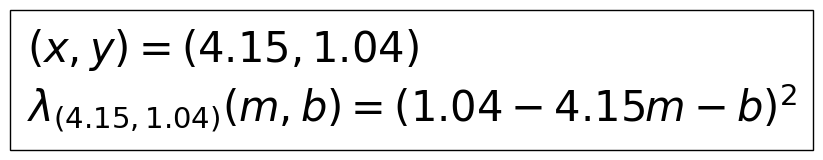

In [ ]:
text=[]
text.append(r"$(x,y)=({0:.2f},{1:.2f})$".format(toplot[featurename],toplot[labelname]))
text.append(r"$\lambda_{{({0:.2f},{1:.2f})}}(m,b)=({1:.2f}-{0:.2f}m-b)^2$".format(toplot[featurename],toplot[labelname]))
textbox(text,fname="singlecost")